In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from matplotlib.pyplot import figure
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

RANDOM_SEED = 41


In [2]:
def update_produv(produv_train):
    
    produv_start=pd.pivot_table(produv_train,index='NPLV',values='SEC', aggfunc={'min'}).reset_index()
    produv_end=pd.pivot_table(produv_train,index='NPLV',values='SEC', aggfunc={'max'}).reset_index()
    ras_med=pd.pivot_table(produv_train,index='NPLV',values='RAS', aggfunc={'mean'}).reset_index()
    ras_sum=pd.pivot_table(produv_train,index='NPLV',values='RAS', aggfunc={'sum'}).reset_index()
    pol_start=pd.pivot_table(produv_train,index='NPLV',values='POL', aggfunc={'max'}).reset_index()
    pol_end=pd.pivot_table(produv_train,index='NPLV',values='POL', aggfunc={'min'}).reset_index()
    
    produv_upd=pd.merge(produv_start,produv_end, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,ras_sum, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,pol_start, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,pol_end, how='left',on='NPLV')
    
    #df.rename(columns = {list(df)[1]:'new_name'}, inplace=True)
    
    produv_upd.rename(columns={list(produv_upd)[1]: 'PRODUVKA_START'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[2]: 'PRODUVKA_END'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[3]: 'RASHOD_SUM'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[4]: 'POL_MAX'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[5]: 'POL_MIN'}, inplace=True)
    
    produv_upd['PRODUVKA_TIME']=produv_upd['PRODUVKA_END']-produv_upd['PRODUVKA_START']
    produv_upd['PRODUVKA_TIME,SEC']=produv_upd['PRODUVKA_TIME'].dt.seconds

    
    return produv_upd

In [3]:
def update_gas(gas_train):
    V_finish=gas_train[['NPLV','Time','V']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    V_finish=V_finish.drop('Time', axis=1)
    V_start=gas_train[['NPLV','Time','V']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    V_start=V_start.drop('Time', axis=1)
    T_finish=gas_train[['NPLV','Time','T']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    T_finish=T_finish.drop('Time', axis=1)
    T_start=gas_train[['NPLV','Time','T']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    T_start=T_start.drop('Time', axis=1)
    O2_sum=pd.pivot_table(gas_train,index='NPLV',values=['O2'], aggfunc={'sum'}).reset_index()
    N2_sum=pd.pivot_table(gas_train,index='NPLV',values=['N2'], aggfunc={'sum'}).reset_index()
    H2_sum=pd.pivot_table(gas_train,index='NPLV',values='H2', aggfunc={'sum'}).reset_index()
    CO2_sum=pd.pivot_table(gas_train,index='NPLV',values=['CO2'], aggfunc={'sum'}).reset_index()
    CO_sum=pd.pivot_table(gas_train,index='NPLV',values=['CO'], aggfunc={'sum'}).reset_index()
    AR_sum=pd.pivot_table(gas_train,index='NPLV',values=['AR'], aggfunc={'sum'}).reset_index()
    TF1_start=gas_train[['NPLV','Time','T фурмы 1']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    TF1_start=TF1_start.drop('Time', axis=1)
    TF1_end=gas_train[['NPLV','Time','T фурмы 1']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    TF1_end=TF1_end.drop('Time', axis=1)
    TF2_start=gas_train[['NPLV','Time','T фурмы 2']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    TF2_start=TF2_start.drop('Time', axis=1)
    TF2_end=gas_train[['NPLV','Time','T фурмы 2']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    TF2_end=TF2_end.drop('Time', axis=1)
    O2_pressure_start=gas_train[['NPLV','Time','O2_pressure']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    O2_pressure_start=O2_pressure_start.drop('Time', axis=1)
    O2_pressure_end=gas_train[['NPLV','Time','O2_pressure']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    O2_pressure_end=O2_pressure_end.drop('Time', axis=1)
    O2_pressure_max=pd.pivot_table(gas_train,index='NPLV',values='O2_pressure', aggfunc={'max'}).reset_index()
    O2_pressure_min=pd.pivot_table(gas_train,index='NPLV',values='O2_pressure', aggfunc={'min'}).reset_index()
    time_start=pd.pivot_table(gas_train,index='NPLV',values='Time', aggfunc={'min'}).reset_index()
    time_end=pd.pivot_table(gas_train,index='NPLV',values='Time', aggfunc={'max'}).reset_index()
    tmp_1=pd.merge(time_start, time_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, V_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, V_finish, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, T_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, T_finish, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, N2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, H2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, CO2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, CO_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, AR_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF1_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF1_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF2_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF2_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_max, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_min, how='left', on='NPLV')
    
    
    tmp_1.rename(columns={list(tmp_1)[1]:'GAS_START'},inplace=True)
    tmp_1.rename(columns={list(tmp_1)[2]: 'GAS_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[3]: 'V_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[4]: 'V_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[5]: 'T_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[6]: 'T_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[7]: 'O2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[8]: 'N2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[9]: 'H2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[10]: 'CO2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[11]: 'CO_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[12]: 'AR_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[13]: 'TF1_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[14]: 'TF1_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[15]: 'TF2_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[16]: 'TF2_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[17]: 'O2_PRESSURE_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[18]: 'O2_PRESSURE_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[19]: 'O2_PRESSURE_MAX'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[20]: 'O2_PRESSURE_MIN'}, inplace=True)
    
    tmp_1['GAS_TIME']=tmp_1['GAS_FINISH']-tmp_1['GAS_START']
    tmp_1['GAS_TIME,SEC']=tmp_1['GAS_TIME'].dt.seconds
    
    tmp_1=tmp_1.drop('GAS_TIME', axis=1)
    tmp_1=tmp_1.drop('GAS_FINISH', axis=1)
    
    
    return tmp_1
    

In [25]:
def update_sip(sip_train_test):
    
    sip_time_start=sip_train_test[['NPLV','DAT_OTD']].sort_values(by=['NPLV','DAT_OTD'], ascending=[True,True]).drop_duplicates('NPLV')
    sip_time_finish=sip_train_test[['NPLV','DAT_OTD']].sort_values(by=['NPLV','DAT_OTD'], ascending=[True,False]).drop_duplicates('NPLV')
    sip_sostav=pd.pivot_table(sip_train_test,index='NPLV',columns='VDSYP',values='VSSYP', aggfunc={'sum'})
    tmp_1=pd.merge(sip_sostav, sip_time_start, how='left',on='NPLV')
    tmp_1=pd.merge(tmp_1, sip_time_finish, how='left',on='NPLV')
    
    tmp_1.rename(columns={list(tmp_1)[1]:'TOTAL_11'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[2]:'TOTAL_104'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[3]:'TOTAL_119'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[4]:'TOTAL_171'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[5]:'TOTAL_344'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[6]:'TOTAL_346'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[7]:'TOTAL_397'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[8]:'TOTAL_408'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[9]:'TOTAL_442'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[10]:'SIP_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[11]:'SIP_FINISH'}, inplace=True)
    tmp_1['SIP_TIME']=tmp_1['SIP_FINISH']-tmp_1['SIP_START']
    tmp_1['SIP_TIME,SEC']=tmp_1['SIP_TIME'].dt.seconds
    
    tmp_1=tmp_1.drop('SIP_TIME', axis=1)
    tmp_1=tmp_1.drop('SIP_FINISH', axis=1)
    

    
    upd_sip=tmp_1[tmp_1['NPLV']<=512322]
    upd_sip_test=tmp_1[tmp_1['NPLV']>512333]
    
    
    return upd_sip,upd_sip_test

In [5]:
def update_chronom(df):
    
    O2_sum=pd.pivot_table(df,index='NPLV',values='O2', aggfunc={'sum'}).reset_index()
        
    O2_sum.rename(columns={list(O2_sum)[1]: 'O2_SUM_CHR'}, inplace=True)      
   
    return O2_sum

In [6]:
def update_lom(lom):
    
    vdl_sum=pd.pivot_table(lom,index='NPLV',values='VDL', aggfunc={'sum'}).reset_index()
    lom_sum=pd.pivot_table(lom,index='NPLV',values='VES', aggfunc={'sum'}).reset_index()
    
    lom_upd=pd.merge(vdl_sum, lom_sum, how='left',on='NPLV')
        
    #df.rename(columns = {list(df)[1]:'new_name'}, inplace=True)
    
    lom_upd.rename(columns={list(lom_upd)[1]: 'VDL_SUM'}, inplace=True)
    lom_upd.rename(columns={list(lom_upd)[2]: 'LOM_SUM'}, inplace=True)
        
    return lom_upd

In [7]:
path='D:/data/'

names=['chronom','chugun','gas','lom','plavki','produv','sip']

chrom_train=pd.read_csv(path+names[0]+'_train.csv', )
chugun_train=pd.read_csv(path+names[1]+'_train.csv')
gas_train=pd.read_csv(path+names[2]+'_train.csv')
lom_train=pd.read_csv(path+names[3]+'_train.csv')
plavki_train=pd.read_csv(path+names[4]+'_train.csv')
produv_train=pd.read_csv(path+names[5]+'_train.csv')
sip_train=pd.read_csv(path+names[6]+'_train.csv')

chrom_test=pd.read_csv(path+names[0]+'_test.csv')
chugun_test=pd.read_csv(path+names[1]+'_test.csv')
gas_test=pd.read_csv(path+names[2]+'_test.csv')
lom_test=pd.read_csv(path+names[3]+'_test.csv')
plavki_test=pd.read_csv(path+names[4]+'_test.csv')
produv_test=pd.read_csv(path+names[5]+'_test.csv')
sip_test=pd.read_csv(path+names[6]+'_test.csv')

target_train=pd.read_csv(path+'target_train.csv')
   

In [8]:
chrom_train.head()

,Unnamed: 0,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,35171,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
1,35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN


In [9]:
chrom_train=chrom_train[chrom_train['VR_NACH']>'2012-01-01 10:28:13']


In [10]:
chrom_train['VR_NACH']=pd.to_datetime(chrom_train['VR_NACH'], format='%Y-%m-%d %H:%M:%S')
chrom_train['VR_KON']=pd.to_datetime(chrom_train['VR_KON'], format='%Y-%m-%d %H:%M:%S')

chugun_train['DATA_ZAMERA']=pd.to_datetime(chugun_train['DATA_ZAMERA'], format='%Y-%m-%d %H:%M:%S')

In [11]:
chrom_train

,Unnamed: 0,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
1,35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
5,35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
...,...,...,...,...,...,...,...
34401,20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN
34402,20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN
34403,20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN
34404,20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN


In [12]:
produv_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729802 entries, 0 to 4729801
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   NPLV    int64  
 1   SEC     object 
 2   RAS     float64
 3   POL     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 144.3+ MB


In [13]:
produv_train.head(10)

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.00,3.92
1,510008,2021-01-01 03:18:28,382.00,3.92
2,510008,2021-01-01 03:18:30,553.00,3.92
3,510008,2021-01-01 03:18:32,701.00,3.92
4,510008,2021-01-01 03:18:34,813.00,3.92
5,510008,2021-01-01 03:18:36,888.00,3.92
6,510008,2021-01-01 03:18:38,939.00,3.45
7,510008,2021-01-01 03:18:40,965.00,2.87
8,510008,2021-01-01 03:18:42,962.45,2.87
9,510008,2021-01-01 03:18:44,959.90,2.87


In [14]:
produv_train['SEC']=pd.to_datetime(produv_train['SEC'], format='%Y-%m-%d %H:%M:%S')

In [15]:
produv_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729802 entries, 0 to 4729801
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   NPLV    int64         
 1   SEC     datetime64[ns]
 2   RAS     float64       
 3   POL     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 144.3 MB


In [16]:
produv_upd=update_produv(produv_train)

In [17]:
produv_upd

,NPLV,PRODUVKA_START,PRODUVKA_END,RASHOD_SUM,POL_MAX,POL_MIN,PRODUVKA_TIME,"PRODUVKA_TIME,SEC"
0,510008,2021-01-01 03:18:26,2021-01-01 04:26:54,838814.0,7.070000,0.77,0 days 01:08:28,4108
1,510009,2021-01-01 04:26:56,2021-01-01 05:25:08,764750.0,4.760000,0.63,0 days 00:58:12,3492
2,510010,2021-01-01 05:25:10,2021-01-01 06:23:50,764170.5,4.349765,0.65,0 days 00:58:40,3520
3,510011,2021-01-01 06:23:52,2021-01-01 07:26:04,733717.0,12.490000,0.79,0 days 01:02:12,3732
4,510012,2021-01-01 07:26:06,2021-01-01 08:36:44,840471.0,5.000000,0.67,0 days 01:10:38,4238
...,...,...,...,...,...,...,...,...
2058,512318,2021-04-26 13:10:12,2021-04-26 14:37:38,978520.0,10.100000,0.80,0 days 01:27:26,5246
2059,512319,2021-04-26 14:37:40,2021-04-26 15:35:46,783447.0,10.040000,0.83,0 days 00:58:06,3486
2060,512320,2021-04-26 15:35:48,2021-04-26 16:36:02,742971.0,7.270000,0.90,0 days 01:00:14,3614
2061,512321,2021-04-26 16:36:04,2021-04-26 18:08:46,964755.5,10.580000,0.92,0 days 01:32:42,5562


In [18]:
gas_train.head()

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172


In [19]:
gas_train['Time']=pd.to_datetime(gas_train['Time'], format='%Y-%m-%d %H:%M:%S')

In [20]:
gas_upd=update_gas(gas_train)

In [21]:
gas_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   NPLV                2063 non-null   int64         
 1   GAS_START           2063 non-null   datetime64[ns]
 2   V_START             2063 non-null   float64       
 3   V_FINISH            2063 non-null   float64       
 4   T_START             2063 non-null   float64       
 5   T_FINISH            2063 non-null   float64       
 6   O2_SUM              2063 non-null   float64       
 7   N2_SUM              2063 non-null   float64       
 8   H2_SUM              2063 non-null   float64       
 9   CO2_SUM             2063 non-null   float64       
 10  CO_SUM              2063 non-null   float64       
 11  AR_SUM              2063 non-null   float64       
 12  TF1_START           2063 non-null   float64       
 13  TF1_FINISH          2063 non-null   float64     

In [22]:
sip_train.head()

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20


In [23]:
sip_train_test=sip_train.append(sip_test)
sip_train_test['DAT_OTD']=pd.to_datetime(sip_train_test['DAT_OTD'],format='%Y-%m-%d %H:%M:%S')
sip_train_test

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
10457,513374,346,Уголь ТО,630,2021-06-29 22:44:40
10458,513374,346,Уголь ТО,2310,2021-06-29 22:46:17
10459,513374,408,изв_ЦОИ,10010,2021-06-29 22:46:23
10460,513374,346,Уголь ТО,670,2021-06-29 22:48:22


In [26]:
sip_upd, sip_upd_test=update_sip(sip_train_test)

In [28]:
sip_upd.head()

,NPLV,TOTAL_11,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,SIP_START,"SIP_TIME,SEC"
0,510008,NaN,NaN,NaN,980.0,NaN,2950.0,NaN,14080.0,2960.0,2021-01-01 03:03:53,1795
1,510009,NaN,1060.0,NaN,960.0,NaN,2930.0,NaN,18830.0,NaN,2021-01-01 03:55:43,2670
2,510010,NaN,990.0,NaN,1050.0,NaN,2990.0,NaN,16080.0,2960.0,2021-01-01 05:09:20,1892
3,510011,NaN,550.0,NaN,980.0,NaN,3620.0,NaN,22150.0,NaN,2021-01-01 06:01:36,3304
4,510012,NaN,2050.0,NaN,1000.0,NaN,2930.0,NaN,19550.0,3010.0,2021-01-01 07:11:44,2315


In [29]:
chronom_upd=update_chronom(chrom_train)

In [30]:
chronom_upd.head()

,NPLV,O2_SUM_CHR
0,510008,2909.0
1,510009,2182.0
2,510010,2841.0
3,510011,10.0
4,510012,3225.0


In [31]:
lom_upd=update_lom(lom_train)

In [32]:
lom_upd.head()

,NPLV,VDL_SUM,LOM_SUM
0,510008,25,76200
1,510009,25,78600
2,510010,48,76300
3,510011,25,84100
4,510012,25,76100


In [33]:
big_data=pd.merge(chronom_upd, lom_upd, on='NPLV', how='left')

In [34]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NPLV        2063 non-null   int64  
 1   O2_SUM_CHR  2063 non-null   float64
 2   VDL_SUM     2063 non-null   int64  
 3   LOM_SUM     2063 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 80.6 KB


In [35]:
big_data=pd.merge(big_data, chugun_train,on='NPLV', how='left')

In [36]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NPLV         2063 non-null   int64         
 1   O2_SUM_CHR   2063 non-null   float64       
 2   VDL_SUM      2063 non-null   int64         
 3   LOM_SUM      2063 non-null   int64         
 4   VES          2063 non-null   float64       
 5   T            2063 non-null   float64       
 6   SI           2063 non-null   float64       
 7   MN           2063 non-null   float64       
 8   S            2063 non-null   float64       
 9   P            2063 non-null   float64       
 10  CR           2063 non-null   float64       
 11  NI           2063 non-null   float64       
 12  CU           2063 non-null   float64       
 13  V            2063 non-null   float64       
 14  TI           2063 non-null   float64       
 15  DATA_ZAMERA  2063 non-null   datetime64[ns]
dtypes: dat

In [37]:
plavki_train[plavki_train['NPLV']==511135]

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
1007,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,63,5 сопловая,161
1008,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,64,5 сопловая,162
1009,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,65,5 сопловая,163
1010,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,66,5 сопловая,164
1011,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,67,5 сопловая,165
...,...,...,...,...,...,...,...,...,...,...
1077,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,42,5 сопловая,42
1078,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,43,5 сопловая,43
1079,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,44,5 сопловая,44
1080,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,45,5 сопловая,45


In [38]:
plavki_train=plavki_train.drop_duplicates('NPLV')

In [39]:
big_data=pd.merge(big_data, plavki_train,on='NPLV', how='left')

In [40]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   NPLV             2063 non-null   int64         
 1   O2_SUM_CHR       2063 non-null   float64       
 2   VDL_SUM          2063 non-null   int64         
 3   LOM_SUM          2063 non-null   int64         
 4   VES              2063 non-null   float64       
 5   T                2063 non-null   float64       
 6   SI               2063 non-null   float64       
 7   MN               2063 non-null   float64       
 8   S                2063 non-null   float64       
 9   P                2063 non-null   float64       
 10  CR               2063 non-null   float64       
 11  NI               2063 non-null   float64       
 12  CU               2063 non-null   float64       
 13  V                2063 non-null   float64       
 14  TI               2063 non-null   float64

In [41]:
big_data=pd.merge(big_data, produv_upd,on='NPLV', how='left')

In [42]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   NPLV               2063 non-null   int64          
 1   O2_SUM_CHR         2063 non-null   float64        
 2   VDL_SUM            2063 non-null   int64          
 3   LOM_SUM            2063 non-null   int64          
 4   VES                2063 non-null   float64        
 5   T                  2063 non-null   float64        
 6   SI                 2063 non-null   float64        
 7   MN                 2063 non-null   float64        
 8   S                  2063 non-null   float64        
 9   P                  2063 non-null   float64        
 10  CR                 2063 non-null   float64        
 11  NI                 2063 non-null   float64        
 12  CU                 2063 non-null   float64        
 13  V                  2063 non-null   float64      

In [43]:
big_data=pd.merge(big_data, gas_upd,on='NPLV', how='left')

In [44]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   NPLV                2063 non-null   int64          
 1   O2_SUM_CHR          2063 non-null   float64        
 2   VDL_SUM             2063 non-null   int64          
 3   LOM_SUM             2063 non-null   int64          
 4   VES                 2063 non-null   float64        
 5   T                   2063 non-null   float64        
 6   SI                  2063 non-null   float64        
 7   MN                  2063 non-null   float64        
 8   S                   2063 non-null   float64        
 9   P                   2063 non-null   float64        
 10  CR                  2063 non-null   float64        
 11  NI                  2063 non-null   float64        
 12  CU                  2063 non-null   float64        
 13  V                   2063 non-null

In [45]:
gas_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   NPLV                2063 non-null   int64         
 1   GAS_START           2063 non-null   datetime64[ns]
 2   V_START             2063 non-null   float64       
 3   V_FINISH            2063 non-null   float64       
 4   T_START             2063 non-null   float64       
 5   T_FINISH            2063 non-null   float64       
 6   O2_SUM              2063 non-null   float64       
 7   N2_SUM              2063 non-null   float64       
 8   H2_SUM              2063 non-null   float64       
 9   CO2_SUM             2063 non-null   float64       
 10  CO_SUM              2063 non-null   float64       
 11  AR_SUM              2063 non-null   float64       
 12  TF1_START           2063 non-null   float64       
 13  TF1_FINISH          2063 non-null   float64     

In [46]:
big_data=pd.merge(big_data, sip_upd,on='NPLV', how='left')

In [47]:
big_data

,NPLV,O2_SUM_CHR,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,SIP_START,"SIP_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,NaN,980.0,NaN,2950.0,NaN,14080.0,2960.0,2021-01-01 03:03:53,1795
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,1060.0,NaN,960.0,NaN,2930.0,NaN,18830.0,NaN,2021-01-01 03:55:43,2670
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,990.0,NaN,1050.0,NaN,2990.0,NaN,16080.0,2960.0,2021-01-01 05:09:20,1892
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,550.0,NaN,980.0,NaN,3620.0,NaN,22150.0,NaN,2021-01-01 06:01:36,3304
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2050.0,NaN,1000.0,NaN,2930.0,NaN,19550.0,3010.0,2021-01-01 07:11:44,2315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2021-04-26 12:58:37,2815
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,2021-04-26 13:57:24,3947
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2021-04-26 15:17:30,2905
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2021-04-26 16:19:13,2015


In [48]:
big_data.columns

Index(['NPLV', 'O2_SUM_CHR', 'VDL_SUM', 'LOM_SUM', 'VES', 'T', 'SI', 'MN', 'S',
       'P', 'CR', 'NI', 'CU', 'V', 'TI', 'DATA_ZAMERA', 'plavka_VR_NACH',
       'plavka_VR_KON', 'plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_STFUT',
       'plavka_TIPE_FUR', 'plavka_ST_FURM', 'plavka_TIPE_GOL', 'plavka_ST_GOL',
       'PRODUVKA_START', 'PRODUVKA_END', 'RASHOD_SUM', 'POL_MAX', 'POL_MIN',
       'PRODUVKA_TIME', 'PRODUVKA_TIME,SEC', 'GAS_START', 'V_START',
       'V_FINISH', 'T_START', 'T_FINISH', 'O2_SUM', 'N2_SUM', 'H2_SUM',
       'CO2_SUM', 'CO_SUM', 'AR_SUM', 'TF1_START', 'TF1_FINISH', 'TF2_START',
       'TF2_FINISH', 'O2_PRESSURE_START', 'O2_PRESSURE_FINISH',
       'O2_PRESSURE_MAX', 'O2_PRESSURE_MIN', 'GAS_TIME,SEC', 'TOTAL_11',
       'TOTAL_104', 'TOTAL_119', 'TOTAL_171', 'TOTAL_344', 'TOTAL_346',
       'TOTAL_397', 'TOTAL_408', 'TOTAL_442', 'SIP_START', 'SIP_TIME,SEC'],
      dtype='object')

In [49]:
big_data['DATA_ZAMERA']=pd.to_datetime(big_data['DATA_ZAMERA'], format='%Y-%m-%d %H:%M:%S')
big_data['plavka_VR_NACH']=pd.to_datetime(big_data['plavka_VR_NACH'], format='%Y-%m-%d %H:%M:%S')
big_data['plavka_VR_KON']=pd.to_datetime(big_data['plavka_VR_KON'], format='%Y-%m-%d %H:%M:%S')


big_data['CHUGUN_TIME']=big_data['DATA_ZAMERA']-big_data['plavka_VR_NACH']
big_data['CHUGUN_TIME,SEC']=big_data['CHUGUN_TIME'].dt.seconds

big_data['PLAVKA_TTL_TIME']=big_data['plavka_VR_KON']-big_data['plavka_VR_NACH']
big_data['PLAVKA_TTL_TIME,SEC']=big_data['PLAVKA_TTL_TIME'].dt.seconds

big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   NPLV                 2063 non-null   int64          
 1   O2_SUM_CHR           2063 non-null   float64        
 2   VDL_SUM              2063 non-null   int64          
 3   LOM_SUM              2063 non-null   int64          
 4   VES                  2063 non-null   float64        
 5   T                    2063 non-null   float64        
 6   SI                   2063 non-null   float64        
 7   MN                   2063 non-null   float64        
 8   S                    2063 non-null   float64        
 9   P                    2063 non-null   float64        
 10  CR                   2063 non-null   float64        
 11  NI                   2063 non-null   float64        
 12  CU                   2063 non-null   float64        
 13  V                 

In [50]:
columns_to_drop=['DATA_ZAMERA',
                'plavka_VR_NACH',      
                 'plavka_VR_KON',  
                 'PRODUVKA_START' , 
                 'PRODUVKA_END' ,  
                 'PRODUVKA_TIME',
                 'GAS_START',
                 'SIP_START',
                 'PLAVKA_TTL_TIME',
                 'CHUGUN_TIME'  
                 
]

In [51]:
big_data=big_data.drop(columns_to_drop, axis=1)

In [52]:
big_data

,NPLV,O2_SUM_CHR,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_119,TOTAL_171,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,980.0,NaN,2950.0,NaN,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,NaN,960.0,NaN,2930.0,NaN,18830.0,NaN,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,NaN,1050.0,NaN,2990.0,NaN,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,NaN,980.0,NaN,3620.0,NaN,22150.0,NaN,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,NaN,1000.0,NaN,2930.0,NaN,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660


In [53]:
big_data

,NPLV,O2_SUM_CHR,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_119,TOTAL_171,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,980.0,NaN,2950.0,NaN,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,NaN,960.0,NaN,2930.0,NaN,18830.0,NaN,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,NaN,1050.0,NaN,2990.0,NaN,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,NaN,980.0,NaN,3620.0,NaN,22150.0,NaN,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,NaN,1000.0,NaN,2930.0,NaN,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660


In [54]:
big_data.columns

Index(['NPLV', 'O2_SUM_CHR', 'VDL_SUM', 'LOM_SUM', 'VES', 'T', 'SI', 'MN', 'S',
       'P', 'CR', 'NI', 'CU', 'V', 'TI', 'plavka_NMZ', 'plavka_NAPR_ZAD',
       'plavka_STFUT', 'plavka_TIPE_FUR', 'plavka_ST_FURM', 'plavka_TIPE_GOL',
       'plavka_ST_GOL', 'RASHOD_SUM', 'POL_MAX', 'POL_MIN',
       'PRODUVKA_TIME,SEC', 'V_START', 'V_FINISH', 'T_START', 'T_FINISH',
       'O2_SUM', 'N2_SUM', 'H2_SUM', 'CO2_SUM', 'CO_SUM', 'AR_SUM',
       'TF1_START', 'TF1_FINISH', 'TF2_START', 'TF2_FINISH',
       'O2_PRESSURE_START', 'O2_PRESSURE_FINISH', 'O2_PRESSURE_MAX',
       'O2_PRESSURE_MIN', 'GAS_TIME,SEC', 'TOTAL_11', 'TOTAL_104', 'TOTAL_119',
       'TOTAL_171', 'TOTAL_344', 'TOTAL_346', 'TOTAL_397', 'TOTAL_408',
       'TOTAL_442', 'SIP_TIME,SEC', 'CHUGUN_TIME,SEC', 'PLAVKA_TTL_TIME,SEC'],
      dtype='object')

In [55]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NPLV                 2063 non-null   int64  
 1   O2_SUM_CHR           2063 non-null   float64
 2   VDL_SUM              2063 non-null   int64  
 3   LOM_SUM              2063 non-null   int64  
 4   VES                  2063 non-null   float64
 5   T                    2063 non-null   float64
 6   SI                   2063 non-null   float64
 7   MN                   2063 non-null   float64
 8   S                    2063 non-null   float64
 9   P                    2063 non-null   float64
 10  CR                   2063 non-null   float64
 11  NI                   2063 non-null   float64
 12  CU                   2063 non-null   float64
 13  V                    2063 non-null   float64
 14  TI                   2063 non-null   float64
 15  plavka_NMZ           2063 non-null   o

In [56]:
round(big_data.describe().T,1)

,count,mean,std,min,25%,50%,75%,max
NPLV,2063.0,511162.5,665.4,510008.0,510584.5,511163.0,511729.5,512322.0
O2_SUM_CHR,2063.0,2281.6,1247.7,0.0,1686.5,2196.0,3147.5,16429.0
VDL_SUM,2063.0,43.5,28.4,4.0,25.0,25.0,66.0,150.0
LOM_SUM,2063.0,69267.4,11230.3,17300.0,62400.0,70500.0,76800.0,155400.0
VES,2063.0,266529.8,12221.4,0.0,264400.0,266000.0,269700.0,312700.0
T,2063.0,1397.3,58.9,0.0,1385.0,1402.0,1417.0,1470.0
SI,2063.0,0.5,0.2,0.0,0.4,0.5,0.6,1.0
MN,2063.0,0.3,0.1,0.0,0.2,0.3,0.3,0.5
S,2063.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
P,2063.0,0.1,0.0,0.0,0.1,0.1,0.1,0.1


In [57]:
big_data=pd.merge(big_data,target_train, how='left', on='NPLV')

In [58]:
big_data

,NPLV,O2_SUM_CHR,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC",TST,C
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,2950.0,NaN,14080.0,2960.0,1795,412,2579,1690,0.060
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,NaN,2930.0,NaN,18830.0,NaN,2670,1384,4004,1683,0.097
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,NaN,2990.0,NaN,16080.0,2960.0,1892,551,2904,1662,0.091
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,NaN,3620.0,NaN,22150.0,NaN,3304,429,3291,1609,0.410
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,NaN,2930.0,NaN,19550.0,3010.0,2315,558,2895,1682,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084,1626,0.145
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843,1643,0.087
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305,1615,0.141
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660,1654,0.270


In [59]:
big_data['O2_SUM_CHR']=big_data.groupby(['TST'])['O2_SUM_CHR'].transform(lambda x: x.replace(0, int(x.mean())))

In [60]:
big_data=big_data.fillna(0)

In [61]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NPLV                 2063 non-null   int64  
 1   O2_SUM_CHR           2063 non-null   float64
 2   VDL_SUM              2063 non-null   int64  
 3   LOM_SUM              2063 non-null   int64  
 4   VES                  2063 non-null   float64
 5   T                    2063 non-null   float64
 6   SI                   2063 non-null   float64
 7   MN                   2063 non-null   float64
 8   S                    2063 non-null   float64
 9   P                    2063 non-null   float64
 10  CR                   2063 non-null   float64
 11  NI                   2063 non-null   float64
 12  CU                   2063 non-null   float64
 13  V                    2063 non-null   float64
 14  TI                   2063 non-null   float64
 15  plavka_NMZ           2063 non-null   o

In [62]:
X_train=big_data.drop(['TST','C'], axis=1)
Y_train=big_data['TST']
Z_train=big_data['C']

In [63]:
X_train

,NPLV,O2_SUM_CHR,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_119,TOTAL_171,TOTAL_344,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,0.0,980.0,0.0,2950.0,0.0,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,0.0,960.0,0.0,2930.0,0.0,18830.0,0.0,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,0.0,1050.0,0.0,2990.0,0.0,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,0.0,980.0,0.0,3620.0,0.0,22150.0,0.0,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,0.0,1000.0,0.0,2930.0,0.0,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,0.0,0.0,0.0,0.0,0.0,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,0.0,0.0,0.0,960.0,0.0,19210.0,2820.0,3947,697,3843
2060,512320,2968.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,0.0,0.0,0.0,1380.0,0.0,19420.0,2830.0,2905,83512,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,0.0,0.0,0.0,520.0,0.0,16100.0,2310.0,2015,84496,3660


In [64]:
Y_train

0       1690
1       1683
2       1662
3       1609
4       1682
        ... 
2058    1626
2059    1643
2060    1615
2061    1654
2062    1630
Name: TST, Length: 2063, dtype: int64

In [65]:
Z_train

0       0.060
1       0.097
2       0.091
3       0.410
4       0.120
        ...  
2058    0.145
2059    0.087
2060    0.141
2061    0.270
2062    0.183
Name: C, Length: 2063, dtype: float64

In [66]:
X = big_data.drop(['TST','C'], axis=1)
y = big_data.pop('TST')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [67]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

O2_SUM_CHR           0.475218
CO2_SUM              0.040424
O2_PRESSURE_MIN      0.029166
V                    0.021402
TOTAL_171            0.017041
TF2_FINISH           0.013469
VDL_SUM              0.009550
POL_MIN              0.006826
GAS_TIME,SEC         0.005599
MN                   0.004609
T                    0.002683
P                    0.001801
TF1_START            0.001040
VES                  0.000000
CU                   0.000000
AR_SUM               0.000000
RASHOD_SUM           0.000000
PRODUVKA_TIME,SEC    0.000000
TF2_START            0.000000
Name: MI Scores, dtype: float64

In [68]:
z=big_data.pop('C')

In [69]:
mi_scores = make_mi_scores(X, z, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

CO2_SUM            0.130217
plavka_STFUT       0.116991
O2_SUM_CHR         0.068852
SI                 0.053402
TF1_FINISH         0.044784
MN                 0.041227
AR_SUM             0.036902
plavka_NAPR_ZAD    0.032509
plavka_TIPE_GOL    0.027745
T                  0.025422
TF2_FINISH         0.018544
V                  0.012561
TI                 0.010321
RASHOD_SUM         0.006697
CU                 0.004165
H2_SUM             0.003602
TOTAL_344          0.000000
TOTAL_119          0.000000
TOTAL_11           0.000000
Name: MI Scores, dtype: float64

In [70]:
produv_test.info()
produv_test['SEC']=pd.to_datetime(produv_test['SEC'], format='%Y-%m-%d %H:%M:%S')
produv_test_upd=update_produv(produv_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692377 entries, 0 to 1692376
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   NPLV    int64  
 1   SEC     object 
 2   RAS     float64
 3   POL     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 51.6+ MB


In [71]:
produv_test_upd.head()

,NPLV,PRODUVKA_START,PRODUVKA_END,RASHOD_SUM,POL_MAX,POL_MIN,PRODUVKA_TIME,"PRODUVKA_TIME,SEC"
0,512324,2021-05-05 17:43:18,2021-05-05 19:04:50,859509.0,10.73,0.89,0 days 01:21:32,4892
1,512327,2021-05-05 21:18:34,2021-05-05 22:40:38,928172.0,8.54,0.89,0 days 01:22:04,4924
2,512328,2021-05-05 22:40:40,2021-05-06 00:13:52,1023656.0,8.59,0.89,0 days 01:33:12,5592
3,512331,2021-05-06 03:15:44,2021-05-06 04:22:46,831766.0,10.23,0.86,0 days 01:07:02,4022
4,512333,2021-05-06 05:50:02,2021-05-06 06:40:58,725326.0,10.42,0.84,0 days 00:50:56,3056


In [72]:
gas_test.info()
gas_test['Time']=pd.to_datetime(gas_test['Time'], format='%Y-%m-%d %H:%M:%S')
gas_test_upd=update_gas(gas_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515868 entries, 0 to 2515867
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   NPLV         int64  
 1   Time         object 
 2   V            float64
 3   T            float64
 4   O2           float64
 5   N2           float64
 6   H2           float64
 7   CO2          float64
 8   CO           float64
 9   AR           float64
 10  T фурмы 1    float64
 11  T фурмы 2    float64
 12  O2_pressure  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 249.5+ MB


In [73]:
gas_test_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   NPLV                780 non-null    int64         
 1   GAS_START           780 non-null    datetime64[ns]
 2   V_START             780 non-null    float64       
 3   V_FINISH            780 non-null    float64       
 4   T_START             780 non-null    float64       
 5   T_FINISH            780 non-null    float64       
 6   O2_SUM              780 non-null    float64       
 7   N2_SUM              780 non-null    float64       
 8   H2_SUM              780 non-null    float64       
 9   CO2_SUM             780 non-null    float64       
 10  CO_SUM              780 non-null    float64       
 11  AR_SUM              780 non-null    float64       
 12  TF1_START           780 non-null    float64       
 13  TF1_FINISH          780 non-null    float64       

In [74]:
sip_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   NPLV     10462 non-null  int64 
 1   VDSYP    10462 non-null  int64 
 2   NMSYP    10462 non-null  object
 3   VSSYP    10462 non-null  int64 
 4   DAT_OTD  10462 non-null  object
dtypes: int64(3), object(2)
memory usage: 408.8+ KB


In [76]:
chrom_test.info()
chrom_test['VR_NACH']=pd.to_datetime(chrom_test['VR_NACH'], format='%Y-%m-%d %H:%M:%S')
chrom_test['VR_KON']=pd.to_datetime(chrom_test['VR_KON'], format='%Y-%m-%d %H:%M:%S')
chrom_test_upd=update_chronom(chrom_test)
chrom_test_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7845 non-null   int64  
 1   NPLV        7845 non-null   int64  
 2   TYPE_OPER   7845 non-null   object 
 3   NOP         7845 non-null   object 
 4   VR_NACH     7845 non-null   object 
 5   VR_KON      7845 non-null   object 
 6   O2          252 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 429.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NPLV        780 non-null    int64  
 1   O2_SUM_CHR  780 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 12.3 KB


In [77]:
lom_test.info()
lom_test_upd=update_lom(lom_test)
lom_test_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NPLV    2632 non-null   int64 
 1   VDL     2632 non-null   int64 
 2   NML     2632 non-null   object
 3   VES     2632 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 82.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   NPLV     780 non-null    int64
 1   VDL_SUM  780 non-null    int64
 2   LOM_SUM  780 non-null    int64
dtypes: int64(3)
memory usage: 24.4 KB


In [79]:
big_data_test=pd.merge(plavki_test,chrom_test_upd, on='NPLV', how='left')
big_data_test=pd.merge(big_data_test,gas_test_upd, on='NPLV', how='left')
big_data_test=pd.merge(big_data_test,sip_upd_test, on='NPLV', how='left')
big_data_test=pd.merge(big_data_test,lom_test_upd, on='NPLV', how='left')
big_data_test=pd.merge(big_data_test,chugun_test, on='NPLV', how='left')

In [91]:
big_data_test

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,...,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,512324,2021-05-05 17:41:21,2021-05-05 18:46:07,Ст3пс/Э,Изл,2,цилиндрическая,2,4-сопл х54,2,...,0.46,0.33,0.027,0.079,0.01,0.01,0.02,0.048,0.030,2021-05-05 17:22:54
1,512327,2021-05-05 21:07:01,2021-05-05 22:02:26,C121TM/ЭТ,МНЛС,5,цилиндрическая,5,4-сопл х54,5,...,0.30,0.33,0.032,0.099,0.01,0.00,0.00,0.050,0.024,2021-05-05 20:00:30
2,512328,2021-05-05 22:03:12,2021-05-05 23:39:32,Ст3пс/Э,Изл,6,цилиндрическая,6,4-сопл х54,6,...,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-05 22:29:21
3,512331,2021-05-06 02:21:46,2021-05-06 03:49:18,25Г2С,Изл,9,цилиндрическая,9,4-сопл х54,9,...,0.54,0.39,0.028,0.115,0.02,0.01,0.03,0.059,0.042,2021-05-06 01:58:11
4,512333,2021-05-06 05:22:03,2021-05-06 06:25:51,C091TM.z01/ЭТ,МНЛС,11,цилиндрическая,11,4-сопл х54,11,...,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-06 05:27:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,513369,2021-06-29 17:08:33,2021-06-29 17:55:50,Ст3сп/Т,МНЛЗ,1047,цилиндрическая,2,601-5,2,...,0.35,0.29,0.035,0.096,0.01,0.01,0.02,0.080,0.062,2021-06-29 16:51:30
776,513370,2021-06-29 18:03:00,2021-06-29 18:49:50,Ст3сп/Т,МНЛЗ,1048,цилиндрическая,3,601-5,3,...,0.39,0.31,0.024,0.097,0.01,0.01,0.02,0.093,0.074,2021-06-29 17:35:57
777,513371,2021-06-29 18:55:21,2021-06-29 19:53:39,Ст3сп/Т,МНЛЗ,1049,цилиндрическая,4,601-5,4,...,0.30,0.27,0.031,0.099,0.01,0.01,0.02,0.066,0.036,2021-06-29 18:52:34
778,513372,2021-06-29 20:18:40,2021-06-29 20:59:18,Ст3сп/Т,МНЛЗ,1050,цилиндрическая,5,601-5,5,...,0.43,0.33,0.026,0.113,0.01,0.01,0.02,0.095,0.070,2021-06-29 19:42:11


<AxesSubplot:>

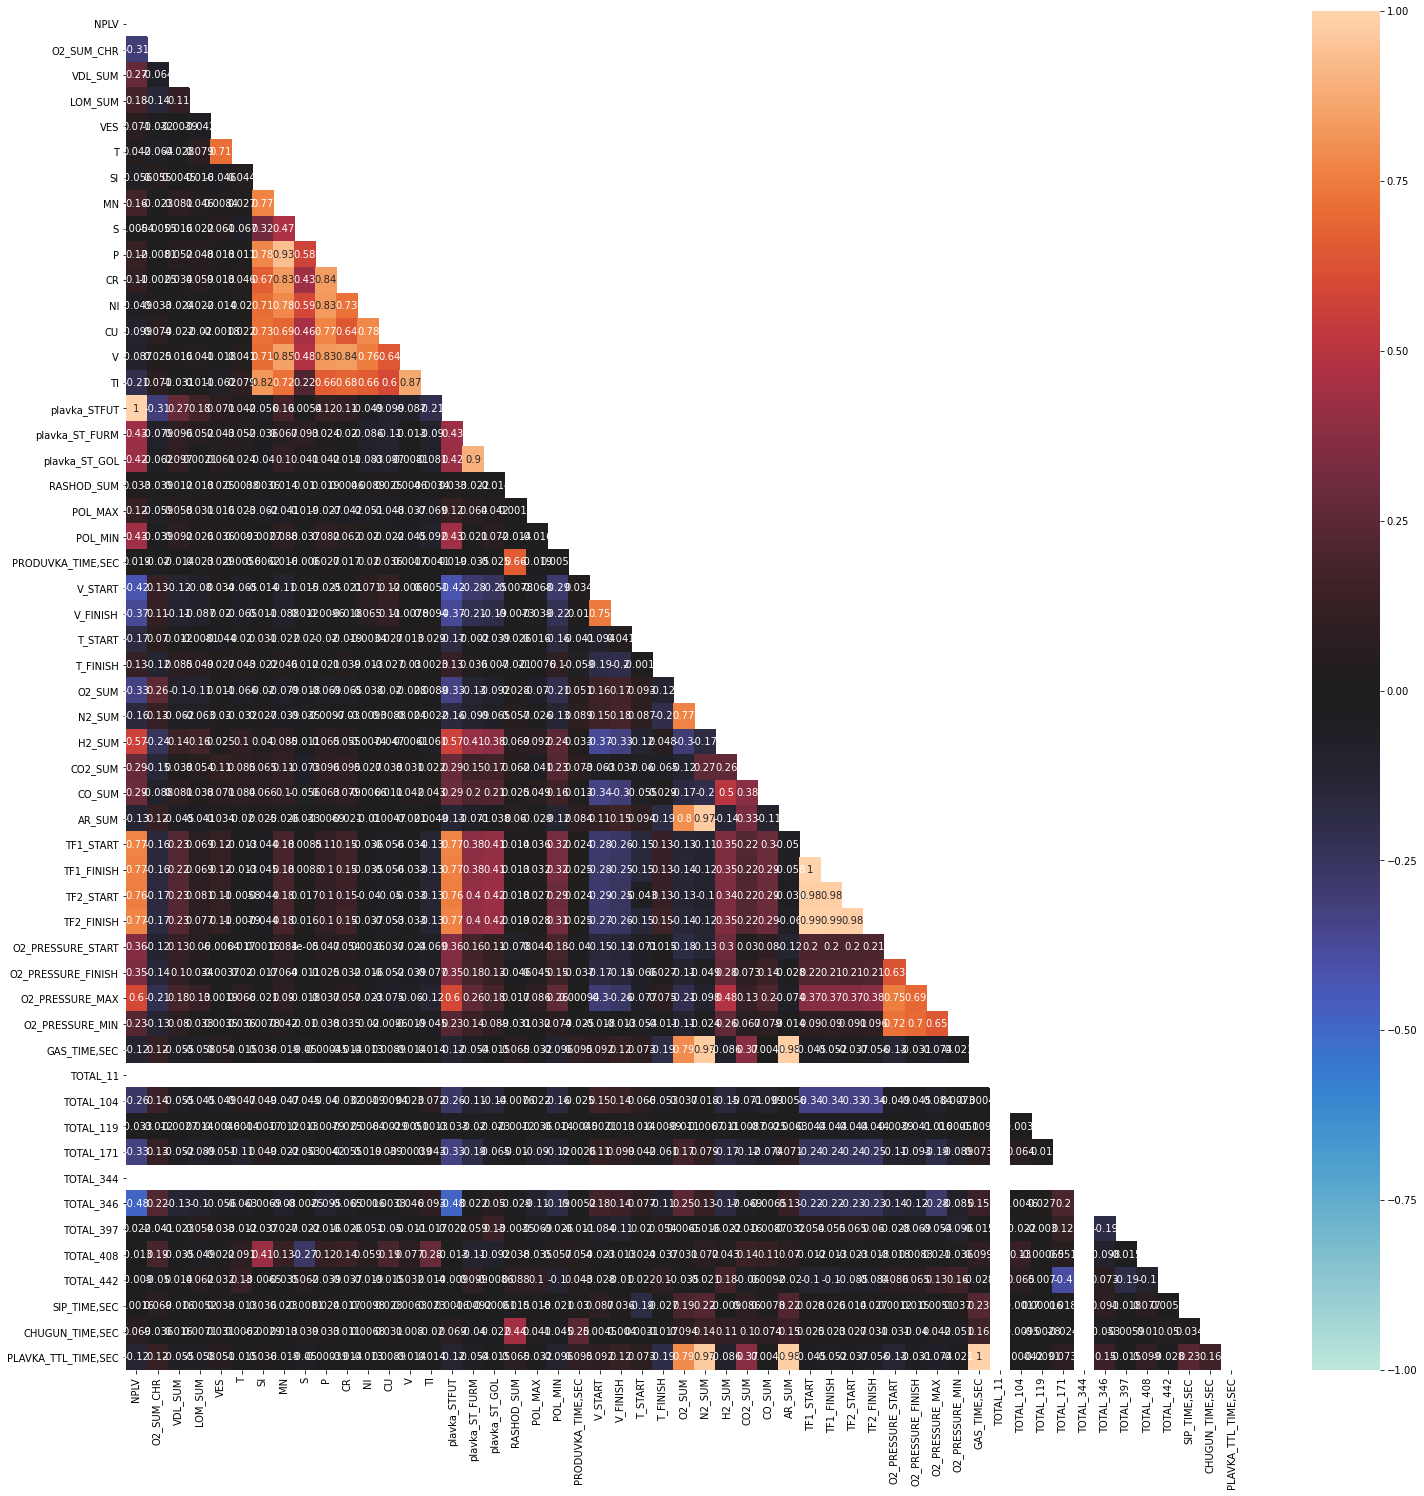

In [80]:
figure(figsize=(25,25))
corr=big_data.corr()
sns.heatmap(corr, annot = True,vmin=-1, vmax=1, center= 0, mask=np.triu(corr))

In [81]:
strong_correlated_cols=[]

In [82]:
#sns.pairplot(big_data)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.65, random_state=12345)

In [84]:
categorical_features_indices = np.where(big_data.dtypes=='object')[0]

In [85]:
categorical_features_indices

array([15, 16, 18, 20], dtype=int64)

In [86]:
from catboost import CatBoostRegressor

model=CatBoostRegressor(iterations=10, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 30.3494616	test: 29.4273723	best: 29.4273723 (0)	total: 177ms	remaining: 1.59s
1:	learn: 29.7318257	test: 28.7886606	best: 28.7886606 (1)	total: 196ms	remaining: 784ms
2:	learn: 29.2700633	test: 28.4149570	best: 28.4149570 (2)	total: 205ms	remaining: 479ms
3:	learn: 28.6633330	test: 27.8459102	best: 27.8459102 (3)	total: 216ms	remaining: 324ms
4:	learn: 28.2387282	test: 27.4054967	best: 27.4054967 (4)	total: 226ms	remaining: 226ms
5:	learn: 27.7709884	test: 26.9963223	best: 26.9963223 (5)	total: 237ms	remaining: 158ms
6:	learn: 27.4445169	test: 26.6655473	best: 26.6655473 (6)	total: 245ms	remaining: 105ms
7:	learn: 27.2120778	test: 26.4824972	best: 26.4824972 (7)	total: 256ms	remaining: 63.9ms
8:	learn: 26.9572840	test: 26.2899857	best: 26.2899857 (8)	total: 266ms	remaining: 29.6ms
9:	learn: 26.6739436	test: 26.0500253	best: 26.0500253 (9)	total: 276ms	remaining: 0us

bestTest = 26.05002535
bestIteration = 9



In [89]:
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression

feature_names = ['F_{}'.format(i) for i in range(X_train.shape[1])]
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_validation, y_validation, feature_names=feature_names)


summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-52',
    num_features_to_select=15,
    steps=5,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level='Silent',
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
summary

{'selected_features': [1,
  12,
  14,
  16,
  17,
  23,
  28,
  41,
  44,
  45,
  46,
  47,
  49,
  50,
  52],
 'eliminated_features_names': ['F_26',
  'F_36',
  'F_34',
  'F_13',
  'F_43',
  'F_0',
  'F_2',
  'F_3',
  'F_4',
  'F_5',
  'F_6',
  'F_7',
  'F_24',
  'F_8',
  'F_9',
  'F_11',
  'F_15',
  'F_18',
  'F_20',
  'F_21',
  'F_22',
  'F_48',
  'F_27',
  'F_10',
  'F_29',
  'F_31',
  'F_32',
  'F_37',
  'F_19',
  'F_30',
  'F_33',
  'F_38',
  'F_39',
  'F_40',
  'F_51',
  'F_35',
  'F_42',
  'F_25'],
 'eliminated_features': [26,
  36,
  34,
  13,
  43,
  0,
  2,
  3,
  4,
  5,
  6,
  7,
  24,
  8,
  9,
  11,
  15,
  18,
  20,
  21,
  22,
  48,
  27,
  10,
  29,
  31,
  32,
  37,
  19,
  30,
  33,
  38,
  39,
  40,
  51,
  35,
  42,
  25],
 'selected_features_names': ['F_1',
  'F_12',
  'F_14',
  'F_16',
  'F_17',
  'F_23',
  'F_28',
  'F_41',
  'F_44',
  'F_45',
  'F_46',
  'F_47',
  'F_49',
  'F_50',
  'F_52']}

In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid={'iterations':range(350,500,50),
            'learning_rate':[0.1,0.5,0.0001],
            'loss_function':['RMSE'],
            'l2_leaf_reg': [1, 3, 7]
            #'depth':range(5,50,1)
            }

clf = GridSearchCV(estimator=model,param_grid=param_grid)
clf.fit(X_train, y_train)


In [ ]:
clf.best_params_